## 1) Anisotropía, longitudes características y números de Reynolds

> Haciendo uso del solver ROTH en GHOST,
resuelva numéricamente la ecuación para un flujo rotante incompresible
con densidad uniforme $ρ_0 = 1$ y $ν = 2 × 10^{−3}$
en un recinto cubico $2π × 2π × 2π$ y resolución espacial `Nx = Ny = 192` y `Nz = 48`.
Hacer uso del Material Adicional.
Para condiciones iniciales nulas para el campo de velocidades
y un forzado mecánico aleatorio con amplitud `f0 = 0.75`
y número de onda `kup = kdn = 1`
integre las ecuaciones hasta $t = 25$.
En el forzado actualice las fases al azar
(con la opción `rand = 2` en el archivo de entrada)
con un tiempo de correlación `cort = 0.5`
(de esta forma las fases de los modos Fourier en el forzado cambiarán cada $∆t = 0.5$).
Utilice una frecuencia de rotación $Ω_z = 8$ y
guarde los espectros cinéticos cada $∆t ∼ 0.5$ y el campo de velocidades cada $∆t ∼ 1.5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray
from common import Output
from ghost_xarray import open_dataset


plt.rc("figure", dpi=100, figsize=(6, 3))

nu = 2e-3
t_max = 25
Δt_save_spectrum = 0.5
Δt_save_field = 1.5

output = Output(
    "problema1/output/",
    dt=Δt_save_spectrum,
    balance=["time", "<v^2>", "<omega^2>", "mechanic injection rate"],
    helicity=["time", "kinetic helicity"],
    kspectrum=["k", "Ev(k)"],
    kspecpara=["k", "Ev(kz)", "Ev_perp(kz)", "Ev_z(kz)"],
    kspecperp=["k", "Ev(kp)", "ev_x,y(kp,kz=0)", "ev_z(kp,kz=0)"],
)

> a) Utilizando la resolución espacial y la condición CFL,
y asumiendo que en el estado turbulento la velocidad característica será $u ∼ 1$,
elija el paso temporal $dt$ que utilizará para la integración numérica.

In [2]:
N = np.array([192, 192, 48])
Δx = 2 * np.pi / np.max(N)
U = 1
Δt_CFL = Δx / U

Δt_CFL

0.032724923474893676

In [3]:
Δt = 0.004

for k, v in {
    "step": Δt,
    "total_steps": t_max / Δt,
    "save_field_steps": Δt_save_field / Δt,
    "save_spectrum_steps": Δt_save_spectrum / Δt,
}.items():
    print(f"{k:>20} = {v:8.3f}")

                step =    0.004
         total_steps = 6250.000
    save_field_steps =  375.000
 save_spectrum_steps =  125.000


> b) Grafique la energía, la enstrofía y la tasa de inyección de energía en función del tiempo
(ayuda: ver la segunda, tercera y cuarta columna del archivo `’balance.txt’`).
Verifique numéricamente la relación
> 
> $$ \frac{dE}{dt} = ε − 2νZ \tag{1} $$
> 
> donde $Z$ es la enstrofía.
Interprete el resultado.

In [4]:
data = output.load_global_output("balance")
data.head(2)

,<v^2>,<omega^2>,mechanic injection rate
time,,,
0.00,0.00000,0.00000,0.000000
0.04,0.00084,0.00084,0.020215


array([<AxesSubplot: xlabel='time'>, <AxesSubplot: xlabel='time'>,
       <AxesSubplot: xlabel='time'>], dtype=object)

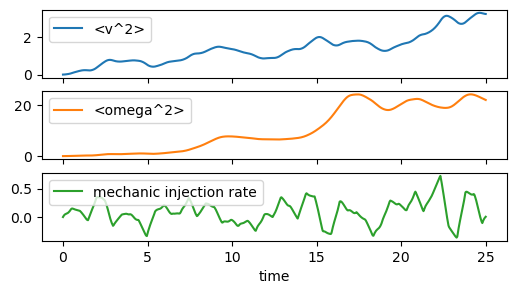

In [5]:
data.plot(subplots=True)

In [6]:
def gradient(df):
    return df.diff() / df.index.to_series().diff()

<AxesSubplot: xlabel='time'>

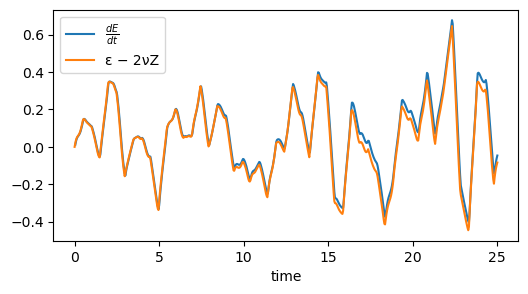

In [7]:
lhs = 0.5 * gradient(data["<v^2>"])
rhs = data["mechanic injection rate"] - 2 * nu * data["<omega^2>"]

pd.DataFrame({r"$\frac{dE}{dt}$": lhs, r"ε − 2νZ": rhs}).plot()

> c) Identifique el tiempo aproximado en el que el sistema llega al régimen turbulento $t^*$.
Grafique el espectro de energía isótropo $E(k)$,
el espectro de energía perpendicular $E(k_⊥)$,
y el espectro de energía paralelo $E(k_∥)$,
promediados en el tiempo desde $t^*$ hasta $t = 25$
(ayuda: el código guarda el espectro perpendicular en los archivos `’kspecperp.*.txt’`,
y el espectro paralelo en `’kspecpara.*.txt’`).
Compare el espectro perpendicular con la predicción fenomenológica.

Elegimos el tiempo $t^*$ como el momento donde el sistema llega al máximo de enstrofía $\langle \omega^2 \rangle$,
es decir, $t^* \approx 18$.

In [8]:
data = output.load_output("kspectrum", "kspecperp", "kspecpara")[["Ev(k)", "Ev(kz)", "Ev(kp)"]]
data

<xarray.Dataset>
Dimensions:  (time: 51, k: 98)
Coordinates:
  * time     (time) float64 0.0 0.5 1.0 1.5 2.0 2.5 ... 23.0 23.5 24.0 24.5 25.0
  * k        (k) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 93.0 94.0 95.0 96.0 97.0
Data variables:
    Ev(k)    (time, k) float64 nan 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Ev(kz)   (time, k) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    Ev(kp)   (time, k) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 nan

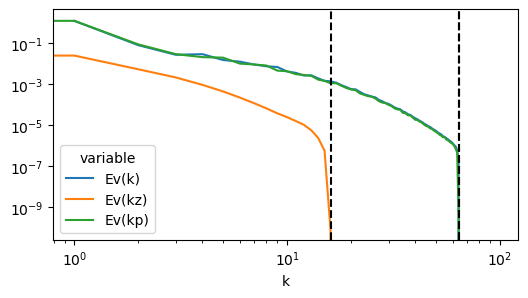

In [9]:
(
    data
    .sel(time=slice(21, None))
    .mean("time")
    .to_array()
    .plot.line(x="k", xscale="log", yscale="log")
)
for n in (N/3):
    plt.axvline(n, linestyle="--", color="black")

Para el espectro perpendicular,
la predicción fenomenológica es que sigue leyes de potencias,
con un exponente $-2$ para el rango inercial,
y un exponente $-5/3$ en el rango disipativo.
Como el $k_\Omega$ de Zeman es mucho mayor al que se resuelve en la simulacion,
no se observa esta última ley de potencia en el espectro.

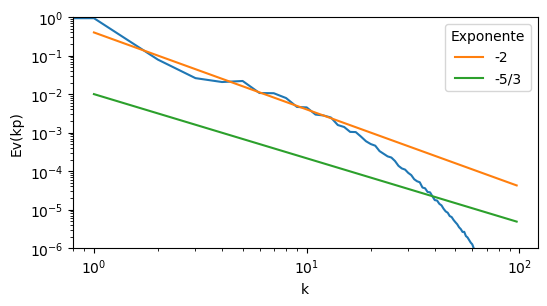

In [10]:
Ek_perp = data["Ev(kp)"].sel(time=slice(18, None)).mean("time")
Ek_perp.plot.line(x="k", xscale="log", yscale="log")
plt.ylim(1e-6, 1)

k = Ek_perp.k
plt.plot(k, 0.4 * k**-2, label="-2")
plt.plot(k, 0.01 * k**-(5/3), label="-5/3")
plt.legend(title="Exponente")

> d) Utilizando los espectros de energía calcule
la longitud integral isótropa $L$,
la longitud perpendicular $L_⊥$,
y la longitud paralela $L_∥$ en función del tiempo.

La longitudes integrales las podemos calcular como

$$ L = \frac{1}{N} \int \frac{2\pi}{k} \; E(k) \; dk $$

donde $ N = \int E(k) \; dk $.

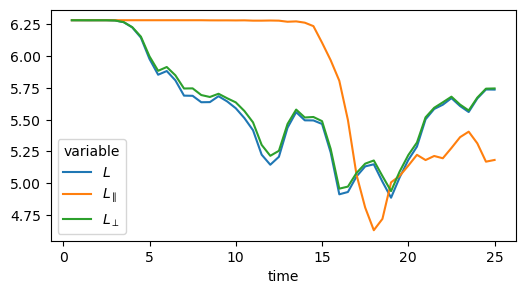

In [11]:
def longitud(E):
    E = E.isel(k=slice(1, None))  # saco k=0
    k = E.k
    L_medio = 2 * np.pi * (E / k).sum("k") / E.sum("k")
    return L_medio


L = data.groupby("time").map(longitud)
L.rename(
    {
        "Ev(k)": "$L$",
        "Ev(kp)": "$L_\perp$",
        "Ev(kz)": "$L_\parallel$",
    }
).to_array().plot.line(x="time")

Para tiempos cortos,
se observa que las longitudes son iguales al tamaño de la caja.
A medida que evoluciona el fluido,
el fluido se empieza a mezclar en la dirección perpendicular a la rotación,
disminuyendo la escala característica de longitud.
En cambio,
en la dirección paralela,
la rotación produce la conformación de estructuras cilindricas a lo largo de dicha dirección.
Al llegar al tiempo $t^*$,
la turbulencia empieza a competir contra el término de rotación,
y la energía se empieza a transferir a escalas de longitud más pequeñas
en la dirección paralela.

> e) Estime el número de Reynolds, el número de Rossby, y el número de onda de Zeman $k_Ω$ en el régimen
turbulento.
Note que como el forzado varía aleatoriamente en el tiempo también varía y puede cambiar de signo.
Por lo tanto, puede obtener una mejor estimación de $k_Ω$
asumiendo que en el estado turbulento $dE/dt ∼ 0$ (en promedio temporal)
y usando $ε ∼ 2νZ$.
Compare $k_Ω$ con el mayor número de onda resuelto.
¿Son isótropas las estructuras en las escalas más pequeñas de este flujo?

Los números de Reynolds $Re$, Rossby $Ro$ y Zeman $k_\Omega$ son:

$$ Re = \frac{UL}{\nu} $$

$$ Ro = \frac{U}{2\Omega L} $$

$$ k_{Zeman} = \left(\frac{\Omega^3}{\epsilon}\right)^\frac{1}{2} $$

In [12]:
U = 1
L = 5
Ω = 8
ε = 2 * nu * output.load_global_output("balance")["<omega^2>"].loc[18:].mean()

pd.Series(
    dict(
        Re=U * L / nu,
        Ro=U / (2 * Ω * L),
        k_Zeman=(Ω**3 / ε) ** 0.5,
    )
)

Re         2500.0000
Ro            0.0125
k_Zeman      77.8489
dtype: float64

Como el número de Reynolds es $Re \sim 2500$,
el flujo se encuentra en un régimen turbuluento.

Por otro lado,
al ser el número de Rossby muy pequeño,
las fuerzas de Coriolis dominan la dinámica.

Finalmente,
como el $k$ de Zeman es mayor al $k$ máximo resuelto en la simulación,
no nos encontramos en el régimen anisótropo.

> f) Para algún tiempo $t > t^*$, grafique un corte de la vorticidad $ω_z$ en el plano $x − z$.
¿Qué observa? ¿Son compatibles las estructuras con lo que esperaba?

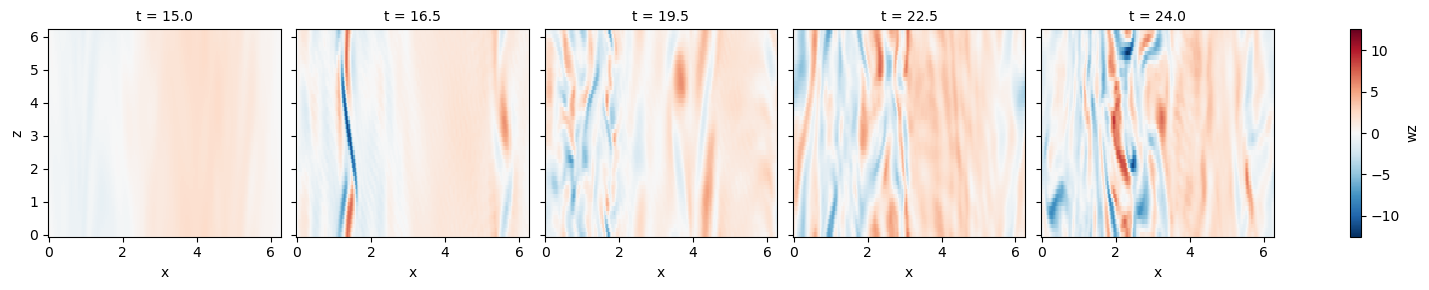

In [13]:
def derivative(x, dim):
    return x.diff(dim) / x[dim].diff(dim)


def rotor(v):
    return xarray.Dataset(
        dict(
            wx=derivative(v["vz"], "y") - derivative(v["vy"], "z"),
            wy=derivative(v["vx"], "z") - derivative(v["vz"], "x"),
            wz=derivative(v["vy"], "x") - derivative(v["vx"], "y"),
        )
    )


w = open_dataset(
    output.path,
    ["vx", "vy", "vz"],
    dt=1.5,
    shape=tuple(N),
    dtype="float32",
).pipe(rotor)

(
    w["wz"]
    .isel(y=96)
    .sel(t=[15, 17, 20, 23, 25], method="nearest")
    .plot(x="x", y="z", col="t")
)

Una vez que se supera el tiempo $t^*$,
se observa el efecto de la turbulencia.
Sin embargo,
se observan estructuras alargadas en la dirección de rotación,
ya que la turbulencia no supera al término de rotación en la dinámica.